In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Overview

**The purpose of this file is to compile all of the different weight files that I wanted to test for this manuscript. The file covers a few different weighting schemes that were developed and ran in succession as the project evolved but it should be clear which cells perform what methods.**

**The only thing to note is that not all weighting methods / perturbations appear in the manuscript. In particular, for each weighting method I adapted uniform weight controls as a pair such that each uneven weighting scheme (with a different eff no of sequences) had a paired uniform weight file that added up to the same eff no of sequences. At least for the moment, all of this code remains but lead nowhere**

# Imports

In [2]:
import numpy as np
import glob
from matplotlib import pyplot as plt
import json

In [3]:
###Including my custom file
import supporting_functions

In [ ]:
###And what may be a non-standard libraries that you'll have to install
from Bio import SeqIO, Phylo
import Levenshtein 

# Writing all weights

This first section is going to write a LOT of weight files!

You should have the below directory structure set up and ready to go.

The next section will specifically write GSC, ACL, and HH weights. For each there will be a mean- and max-scaled file as well as a set of uniform weights corresponding to the max-file. Additionally I'm writing a plain old uniform file to start. 

So for each protein in the fasta_directory these cells directly below will write 10 separate weight files

In [ ]:
fasta_directory = '../Data/psicov150_aln_pdb/aln_fasta_max1k/'
tree_directory = '../Data/psicov150_aln_pdb/aln_fasta_max1k_iqtree/'

weight_output_dir = '../Data/weights/'

In [ ]:
for fasta_file in sorted(glob.glob(fasta_directory+'*.fasta'))[:]:
    prot_name = fasta_file.split('/')[-1].split('.')[0]
    #First read in sequence data
    records = list(SeqIO.parse(fasta_file, 'fasta'))
    #And the tree
    tree_loc = tree_directory+'{}.fasta.treefile'.format(prot_name)
    try:
        tree = Phylo.read(tree_loc, rooted=False, format='newick')
    except FileNotFoundError:
        continue
    #Root the tree with my mid-point algorithm
    tree = supporting_functions.MP_root(tree)
    
    #First write basic uniform weights    
    weight_val = 1.0
    with open(weight_output_dir+'{}_uniform.weights'.format(prot_name),'w') as outfile:
        for record in records:
            outfile.write('{}\n'.format(weight_val))
    ##############################################################################
    #Move on to GSC weights
    ##############################################################################
    print('####################GSC', prot_name, len(records), len(tree.get_terminals()))    
    weights_dict =  weighting_methods.calc_GSC_weights(tree)
    weights_dict_id = {}
    for i,j in weights_dict.items():
        weights_dict_id[i.name] = j
    
    #Mean scale these
    mean_GSC = np.mean(list(weights_dict_id.values()))
    keys, vals = zip(*list(weights_dict_id.items()))
    vals = np.array(vals)/mean_GSC
    new_dict = dict(zip(keys, vals))
    
    #And write to file
    with open(weight_output_dir+'{}_GSC_{}.weights'.format(prot_name, 'meanScale'),'w') as outfile:
        for record in records:
            outfile.write('{}\n'.format(new_dict[record.id]))
    print(np.sum(list(new_dict.values())))   
    
    #Max scale them
    max_GSC = np.max(list(weights_dict_id.values()))
    keys, vals = zip(*list(weights_dict_id.items()))
    vals = np.array(vals)/max_GSC
    new_dict = dict(zip(keys, vals))
    
    #And write to file
    with open(weight_output_dir+'{}_GSC_{}.weights'.format(prot_name, 'maxScale'),'w') as outfile:
        for record in records:
            outfile.write('{}\n'.format(new_dict[record.id]))
    print(np.sum(list(new_dict.values())))   
    
    ### Write corresponding uniform for max scale
    weight_val = np.sum(list(new_dict.values()))/len(records)
    with open(weight_output_dir+'{}_GSC_maxScale_uniform.weights'.format(prot_name),'w') as outfile:
        for record in records:
            outfile.write('{}\n'.format(weight_val))
    
    ##############################################################################
    #ACL weights (reload and re-root the tree)
    ##############################################################################
    try:
        tree = Phylo.read(tree_loc, rooted=False, format='newick')
    except FileNotFoundError:
        continue
    tree = supporting_functions.MP_root(tree)
    print('####################ACL', prot_name, len(records), len(tree.get_terminals()))

    #Get ACL weights
    weights_dict, new_tree =  weighting_methods.calc_ACL_weights(tree)
    weights_dict_id = {}
    for i,j in weights_dict.items():
        weights_dict_id[i.name] = j
        
    #Mean scale
    mean_ACL = np.mean(list(weights_dict_id.values()))
    keys, vals = zip(*list(weights_dict_id.items()))
    vals = np.array(vals)/mean_ACL
    new_dict = dict(zip(keys, vals))
    
    #And write
    with open(weight_output_dir+'{}_ACL_{}.weights'.format(prot_name, 'meanScale'),'w') as outfile:
        for record in records:
            outfile.write('{}\n'.format(new_dict[record.id]))
    print(np.sum(list(new_dict.values())))
    
    #Max scale
    max_ACL = np.max(list(weights_dict_id.values()))
    keys, vals = zip(*list(weights_dict_id.items()))
    vals = np.array(vals)/max_ACL
    new_dict = dict(zip(keys, vals))
    
    #And write
    with open(weight_output_dir+'{}_ACL_{}.weights'.format(prot_name, 'maxScale'),'w') as outfile:
        for record in records:
            outfile.write('{}\n'.format(new_dict[record.id]))
    print(np.sum(list(new_dict.values()))) 
    
    ### Write corresponding uniform for max scale
    weight_val = np.sum(list(new_dict.values()))/len(records)
    with open(weight_output_dir+'{}_ACL_maxScale_uniform.weights'.format(prot_name),'w') as outfile:
        for record in records:
            outfile.write('{}\n'.format(weight_val))
            
            
    ##############################################################################
    #HH weights
    ##############################################################################
    print('####################HH', prot_name, len(records), len(tree.get_terminals()))
    weights_dict = weighting_methods.calc_HH_weights(records)
    #Mean scale
    weights_array = np.array(list(weights_dict.values()))    
    mean_HH = np.mean(list(weights_dict.values()))
    keys, vals = zip(*list(weights_dict.items()))
    vals = np.array(vals)/mean_HH
    new_dict = dict(zip(keys, vals))
    #Write 
    with open(weight_output_dir+'{}_HH_{}.weights'.format(prot_name, 'meanScale'),'w') as outfile:
        for record in records:
            outfile.write('{}\n'.format(new_dict[record.id]))
    print(np.sum(list(new_dict.values())))
    #Max scale
    max_HH = np.max(list(weights_dict.values()))
    keys, vals = zip(*list(weights_dict.items()))
    vals = np.array(vals)/max_HH
    new_dict = dict(zip(keys, vals))
    #Write
    with open(weight_output_dir+'{}_HH_{}.weights'.format(prot_name, 'maxScale'),'w') as outfile:
        for record in records:
            outfile.write('{}\n'.format(new_dict[record.id]))
    print(np.sum(list(new_dict.values())))
    
    #And finally write corresponding uniform for max scale
    weight_val = np.sum(list(new_dict.values()))/len(records)
    with open(weight_output_dir+'{}_HH_maxScale_uniform.weights'.format(prot_name),'w') as outfile:
        for record in records:
            outfile.write('{}\n'.format(weight_val))

**Print prot names to make a bash array**

(just a little something I used in my scripting, not necessary)

In [ ]:
prot_names = []
for fasta_file in sorted(glob.glob('../../Phylogenetic_couplings/Data/'
                                   'psicov150_aln_pdb/aln_fasta_max1k/*.fasta'))[:]:
    #Read in sequence data and tree
    records = list(SeqIO.parse(fasta_file, 'fasta'))
    prot_name = fasta_file.split('/')[-1].split('.')[0]
    prot_names.append(prot_name)
for i in prot_names:
    print('"{}"'.format(i), end=" ")

# This section uses the RelTime algorithm

Specifically to scale the trees and re-do calculations for GSC and ACL weights.

Code functions basically the same as above, and writes 6 files for each protein: mean and max scaled GSC and ACL weights, and corresponding uniform weight controls for the two max files.

In [ ]:
fasta_directory = '../Data/psicov150_aln_pdb/aln_fasta_max1k/'
tree_directory = '../Data/psicov150_aln_pdb/aln_fasta_max1k_iqtree/'

weight_output_dir = '../Data/weights/'

In [ ]:
for fasta_file in sorted(glob.glob(fasta_directory+'*.fasta'))[:]:
    #Read in sequence data and tree
    records = list(SeqIO.parse(fasta_file, 'fasta'))
    prot_name = fasta_file.split('/')[-1].split('.')[0]
    tree_loc = tree_directory+'{}.fasta.treefile'.format(prot_name)
    try:
        tree = Phylo.read(tree_loc, rooted=False, format='newick')
    except FileNotFoundError:
        continue  
    tree = supporting_functions.MP_root(tree)
    ##############################################
    ###RelTime transformation
    ##############################################
    tree.root.branch_length = 0.0
    tree = supporting_functions.rel_time_AJH(tree)
    for node in tree.get_terminals() + tree.get_nonterminals():
        if node == tree.root:
            continue
        node.branch_length = node.branch_length/node.rate
    tree.root.branch_length = None


    ##############################################################################
    #GSC weights as above
    ##############################################################################
    print('####################GSC', prot_name, len(records), len(tree.get_terminals()))
    weights_dict =  weighting_methods.calc_GSC_weights(tree)
    weights_dict_id = {}
    for i,j in weights_dict.items():
        weights_dict_id[i.name] = j
    
    #Mean scale them
    mean_GSC = np.mean(list(weights_dict_id.values()))
    keys, vals = zip(*list(weights_dict_id.items()))
    vals = np.array(vals)/mean_GSC
    new_dict = dict(zip(keys, vals))
    with open(weight_output_dir+'{}_GSC_{}.RelTime.weights'.format(prot_name, 'meanScale'),'w') as outfile:
        for record in records:
            outfile.write('{}\n'.format(new_dict[record.id]))
    print(np.sum(list(new_dict.values())))  
    
    #Max scale them
    max_GSC = np.max(list(weights_dict_id.values()))
    keys, vals = zip(*list(weights_dict_id.items()))
    vals = np.array(vals)/max_GSC
    new_dict = dict(zip(keys, vals))
    with open(weight_output_dir+'{}_GSC_{}.RelTime.weights'.format(prot_name, 'maxScale'),'w') as outfile:
        for record in records:
            outfile.write('{}\n'.format(new_dict[record.id]))
    print(np.sum(list(new_dict.values())))   
    
    ### Write corresponding uniform for max scale
    weight_val = np.sum(list(new_dict.values()))/len(records)
    with open(weight_output_dir+'{}_GSC_maxScale_uniform.RelTime.weights'.format(prot_name),'w') as outfile:
        for record in records:
            outfile.write('{}\n'.format(weight_val))
    
    ##############################################################################
    #ACL weights (reload and re-root the tree first)
    ##############################################################################
    try:
        tree = Phylo.read(tree_loc, rooted=False, format='newick')
    except FileNotFoundError:
        continue  
    tree = supporting_functions.MP_root(tree)
    ##############################################
    ###RelTime transformation
    ##############################################
    tree.root.branch_length = 0.0
    tree = supporting_functions.rel_time_AJH(tree)
    for node in tree.get_terminals() + tree.get_nonterminals():
        if node == tree.root:
            continue
        node.branch_length = node.branch_length/node.rate
    tree.root.branch_length = None

    print('####################ACL', prot_name, len(records), len(tree.get_terminals()))
    #Get ACL weights
    weights_dict, new_tree =  weighting_methods.calc_ACL_weights(tree)
    weights_dict_id = {}
    for i,j in weights_dict.items():
        weights_dict_id[i.name] = j
    #Mean scale
    mean_ACL = np.mean(list(weights_dict_id.values()))
    keys, vals = zip(*list(weights_dict_id.items()))
    vals = np.array(vals)/mean_ACL
    new_dict = dict(zip(keys, vals))
    with open(weight_output_dir+'{}_ACL_{}.RelTime.weights'.format(prot_name, 'meanScale'),'w') as outfile:
        for record in records:
            outfile.write('{}\n'.format(new_dict[record.id]))
    print(np.sum(list(new_dict.values())))  

    #Max scale
    max_ACL = np.max(list(weights_dict_id.values()))
    keys, vals = zip(*list(weights_dict_id.items()))
    vals = np.array(vals)/max_ACL
    new_dict = dict(zip(keys, vals))
    with open(weight_output_dir+'{}_ACL_{}.RelTime.weights'.format(prot_name, 'maxScale'),'w') as outfile:
        for record in records:
            outfile.write('{}\n'.format(new_dict[record.id]))
    print(np.sum(list(new_dict.values())))  

    ### Write corresponding uniform for max scale
    weight_val = np.sum(list(new_dict.values()))/len(records)
    with open(weight_output_dir+'{}_ACL_maxScale_uniform.RelTime.weights'.format(prot_name),'w') as outfile:
        for record in records:
            outfile.write('{}\n'.format(weight_val))

# Read in output log information and write the corresponding uniform weights for simple sequence re-weighting methods

This information ultimately did not make it into the manuscript

In [ ]:
fasta_directory = '../Data/psicov150_aln_pdb/aln_fasta_max1k/'

weight_output_dir = '../Data/weights/'

In [ ]:
with open('../Results/CCMPredPy_MetaData.log', 'r') as infile:
    lines = infile.readlines()

In [ ]:
for line in lines[:]:
    temp_dicty = json.loads(line.strip('#>META> '))
    outfile = temp_dicty['workflow'][0]['contact_map']['matfile']
    if 'simple' in outfile:
        prot_name = outfile.split('.')[0]
        weighting_val = outfile.split('_')[1].strip('.mat')
        neff = temp_dicty['workflow'][0]['msafile']['neff']
        fasta_file = fasta_directory+'{}.fasta'.format(prot_name)
        records = list(SeqIO.parse(fasta_file, 'fasta'))
        ### First write basic uniform weights    
        weight_val = neff/len(records)
        with open(weight_output_dir+'{}_simple_{}_uniform.weights'.format(prot_name, weighting_val),'w') as outfile:
            for record in records:
                outfile.write('{}\n'.format(weight_val))

# Finally writing my own version of simple sequence weights as well as a slightly more complicated version that I call similarity-adjusted

The code is slow / inefficient, and I'm sure there is a better solution here but I'm relatively unconcerned at the moment having ensured that it gives proper results.

Note that you'll want to run this for variable `id_param` values (0.1 to 0.9 show up in the manuscript) and just because it's how I initially wrote it, `id_param` is 1 - the lambda parameter that shows up in the manuscript so the math might look a bit strange here 

In [7]:
fasta_directory = '../Data/psicov150_aln_pdb/aln_fasta_max1k/'
tree_directory = '../Data/psicov150_aln_pdb/aln_fasta_max1k_iqtree/'

weight_output_dir = '../Data/weights/'

In [ ]:
id_param = 0.7

for fasta_file in sorted(glob.glob(fasta_directory+'*.fasta'))[:]:
    #Read in sequence data and tree
    records = list(SeqIO.parse(fasta_file, 'fasta'))
    prot_name = fasta_file.split('/')[-1].split('.')[0]
#     tree_loc = tree_directory+'{}.fasta.treefile'.format(prot_name)
#     try:
#         tree = Phylo.read(tree_loc, rooted=False, format='newick')
#     except FileNotFoundError:
#         continue  
    
    ###Initialize the weights dictionaries so each sequence gets a value of 1
    weights_dict_basic = {}
    for record in records:
        weights_dict_basic[record.id] = 1
        
    weights_dict_complex = {}
    for record in records:
        weights_dict_complex[record.id] = 1
    
    ###Gross double for loop 
    seq_len = len(str(records[0].seq))
    for i, record_i in enumerate(records):
        for j in range(i+1, len(records)):
            ###Get the hamming distance between the strings (divided by the length)
            scaled_dist = Levenshtein.hamming(str(record_i.seq), str(records[j].seq))/seq_len
            if scaled_dist <= id_param:
                weights_dict_basic[record_i.id] += 1
                weights_dict_basic[records[j].id] += 1                
                weights_dict_complex[record_i.id] += (id_param-scaled_dist)/id_param
                weights_dict_complex[records[j].id] += (id_param-scaled_dist)/id_param

    
    for key, val in weights_dict_basic.items():
        weights_dict_basic[key] = 1./val
        
    for key, val in weights_dict_complex.items():
        weights_dict_complex[key] = 1./val
            
    with open(weight_output_dir+'{}_simple_{}.weights'.format(prot_name, round(1.0-id_param,2)),'w') as outfile:
        for record in records:
            outfile.write('{}\n'.format(weights_dict_basic[record.id]))
            
    with open(weight_output_dir+'{}_simpleish_{}.weights'.format(prot_name, round(1.0-id_param,2)),'w') as outfile:
        for record in records:
            outfile.write('{}\n'.format(weights_dict_complex[record.id]))

# Checking correlations

In [4]:
from scipy import stats
import numpy as np

In [20]:
prot_name = '1aoeA'
# a = np.genfromtxt(weight_output_dir+'{}_GSC_meanScale.weights'.format(prot_name))
# b = np.genfromtxt(weight_output_dir+'{}_ACL_meanScale.weights'.format(prot_name))

a = np.genfromtxt(weight_output_dir+'{}_simple_0.8.weights'.format(prot_name))
b = np.genfromtxt(weight_output_dir+'{}_simpleish_0.8.weights'.format(prot_name))

SpearmanrResult(correlation=0.9852889085534186, pvalue=0.0)

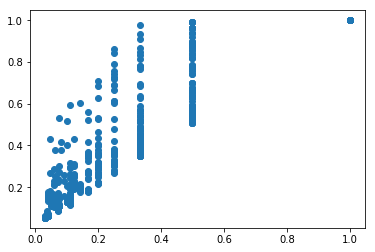

In [21]:
fig, ax = plt.subplots()
ax.plot(a, b, marker='o', linestyle='')
stats.spearmanr(a,b)